In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data loading and cleaning

In [4]:
data = pd.read_csv('dataset/TravelInsurancePrediction.csv')

In [5]:
data.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [6]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
# Normalize and map Yes/No -> 1/0
for col in ["FrequentFlyer", "EverTravelledAbroad", "GraduateOrNot"]:
    data[col] = (
        data[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({"yes": 1, "no": 0})
        .astype("Int64")  # use Int64 to tolerate any missing values
    )

# Optional: quick check
data[["FrequentFlyer", "EverTravelledAbroad"]].head()

/tmp/ipykernel_398151/4065753487.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"yes": 1, "no": 0})


,FrequentFlyer,EverTravelledAbroad
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0


In [12]:
if data.duplicated().sum() > 0:
    print(
        f"There are {data.duplicated().sum()} duplicated values in the dataset"
    )
    print("Removing duplicated data...")
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)
    print("Done")
else:
    print("There are no duplicated values in the dataset")

There are 738 duplicated values in the dataset
Removing duplicated data...
Done


In [13]:
col = "Employment Type"
if col in data.columns:
    # Normalize strings (trim spaces, consistent casing)
    data[col] = (
        data[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({"nan": None})
    )

    # Create dummies; set drop_first=True to avoid multicollinearity
    dummies = pd.get_dummies(data[col], prefix="EmploymentType", dummy_na=False)
    data = pd.concat([data.drop(columns=[col]), dummies], axis=1)

    # Quick check
    print("Encoded columns added:", list(dummies.columns))
else:
    print(f"Column '{col}' not found in DataFrame")

Encoded columns added: ['EmploymentType_government sector', 'EmploymentType_private sector/self employed']


In [14]:
data["Age"] = data["Age"].astype("Int64")  # Ensure Age is also Int64

In [15]:
data.head()

,Age,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,EmploymentType_government sector,EmploymentType_private sector/self employed
0,31,1,400000,6,1,0,0,0,True,False
1,31,1,1250000,7,0,0,0,0,False,True
2,34,1,500000,4,1,0,0,1,False,True
3,28,1,700000,3,1,0,0,0,False,True
4,28,1,700000,8,1,1,0,0,False,True


In [18]:
# Ensure one-hot columns are numeric 0/1
for col in ["EmploymentType_government sector", "EmploymentType_private sector/self employed"]:
    if col in data.columns:
        if data[col].dtype == "bool":
            data[col] = data[col].replace({True: 1, False: 0})
        data[col] = data[col].astype("Int64")

/tmp/ipykernel_398151/241660892.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace({True: 1, False: 0})
/tmp/ipykernel_398151/241660892.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace({True: 1, False: 0})


In [50]:
# Drop selected columns and proceed with retraining pipeline
cols_to_drop = [
    "ChronicDiseases",
    "EmploymentType_government sector",
    "EmploymentType_private sector/self employed",
]
existing = [c for c in cols_to_drop if c in data.columns]
if existing:
    data = data.drop(columns=existing)
    print("Dropped columns:", existing)
else:
    print("No requested columns found to drop.")

Dropped columns: ['ChronicDiseases', 'EmploymentType_government sector', 'EmploymentType_private sector/self employed']


# Data Analysis

In [20]:
data.corr()

,Age,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,EmploymentType_government sector,EmploymentType_private sector/self employed
Age,1.000000,0.019119,-0.005029,0.014250,0.000922,-0.032255,-0.023111,0.067536,0.152233,-0.152233
GraduateOrNot,0.019119,1.000000,0.125303,0.026962,0.033585,-0.032201,0.024472,0.031770,0.153584,-0.153584
AnnualIncome,-0.005029,0.125303,1.000000,-0.012626,0.016386,0.292793,0.429940,0.293913,-0.238633,0.238633
FamilyMembers,0.014250,0.026962,-0.012626,1.000000,-0.014822,-0.022088,-0.022051,0.084907,-0.012996,0.012996
ChronicDiseases,0.000922,0.033585,0.016386,-0.014822,1.000000,-0.077009,0.020274,-0.010015,0.013980,-0.013980
FrequentFlyer,-0.032255,-0.032201,0.292793,-0.022088,-0.077009,1.000000,0.206200,0.127426,-0.119851,0.119851
EverTravelledAbroad,-0.023111,0.024472,0.429940,-0.022051,0.020274,0.206200,1.000000,0.301224,-0.140615,0.140615
TravelInsurance,0.067536,0.031770,0.293913,0.084907,-0.010015,0.127426,0.301224,1.000000,-0.076309,0.076309
EmploymentType_government sector,0.152233,0.153584,-0.238633,-0.012996,0.013980,-0.119851,-0.140615,-0.076309,1.000000,-1.000000
EmploymentType_private sector/self employed,-0.152233,-0.153584,0.238633,0.012996,-0.013980,0.119851,0.140615,0.076309,-1.000000,1.000000


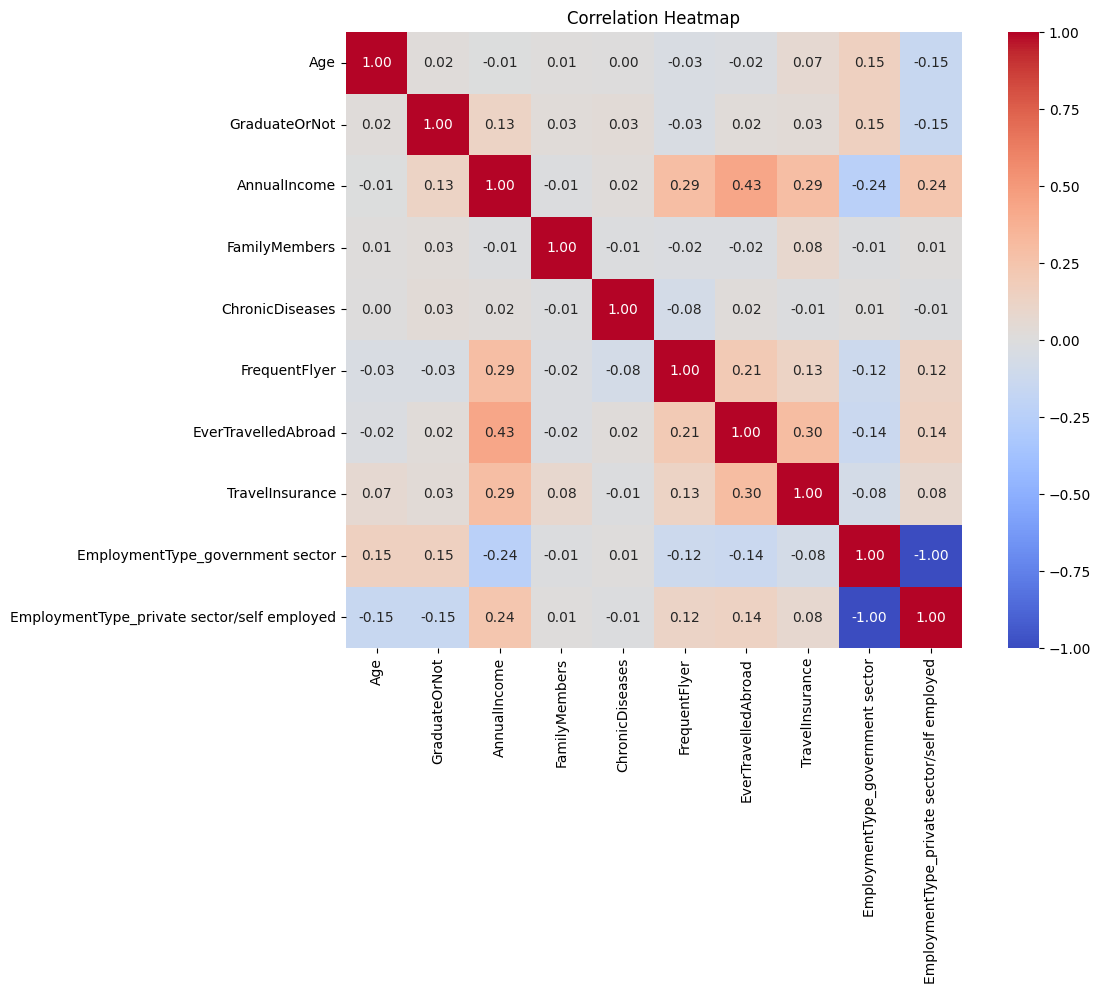

In [23]:
plt.figure(figsize=(12, 8))
plt.title("Correlation Heatmap")
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.show()

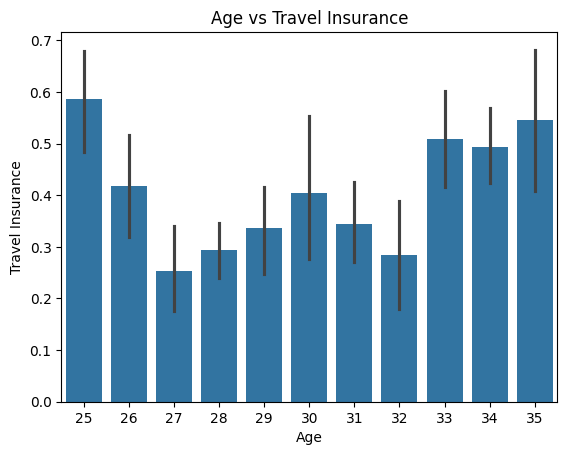

In [26]:
# Bar Graph of age vs travel insurance
sns.barplot(x="Age", y="TravelInsurance", data=data)
plt.title("Age vs Travel Insurance")
plt.xlabel("Age")
plt.ylabel("Travel Insurance")
plt.show()

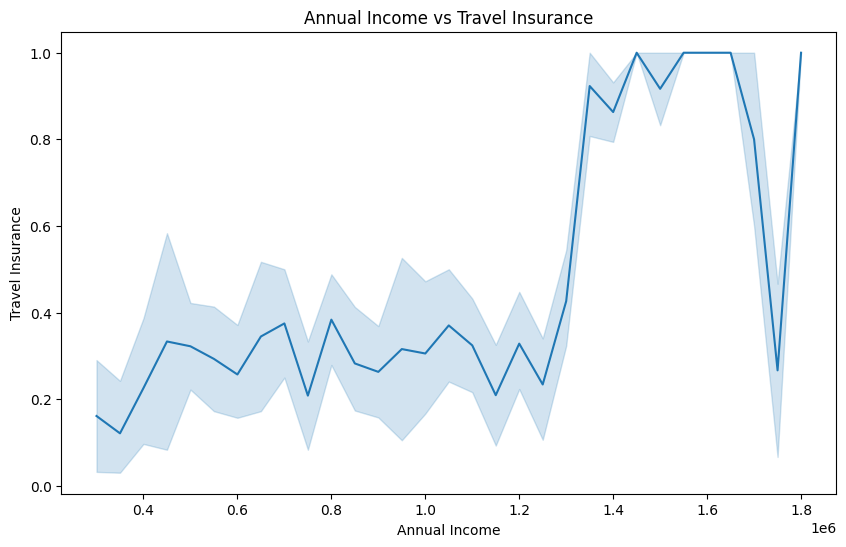

In [29]:
# Annual Income vs Travel Insurance line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="AnnualIncome", y="TravelInsurance", estimator="mean")
plt.title("Annual Income vs Travel Insurance")
plt.xlabel("Annual Income")
plt.ylabel("Travel Insurance")
plt.show()

In [36]:
# rows where Annual income is b/w 1.6M and 1.8M
filtered_data = data[(data["AnnualIncome"] >= 1600000) & (data["AnnualIncome"] <= 1800000)]
filtered_data.head()

,Age,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,EmploymentType_government sector,EmploymentType_private sector/self employed
84,25,0,1700000,4,0,1,0,1,0,1
107,25,1,1700000,3,0,1,0,1,0,1
130,25,1,1750000,4,0,0,1,1,0,1
176,25,0,1700000,3,1,1,0,0,0,1
294,25,1,1700000,2,1,1,0,1,0,1


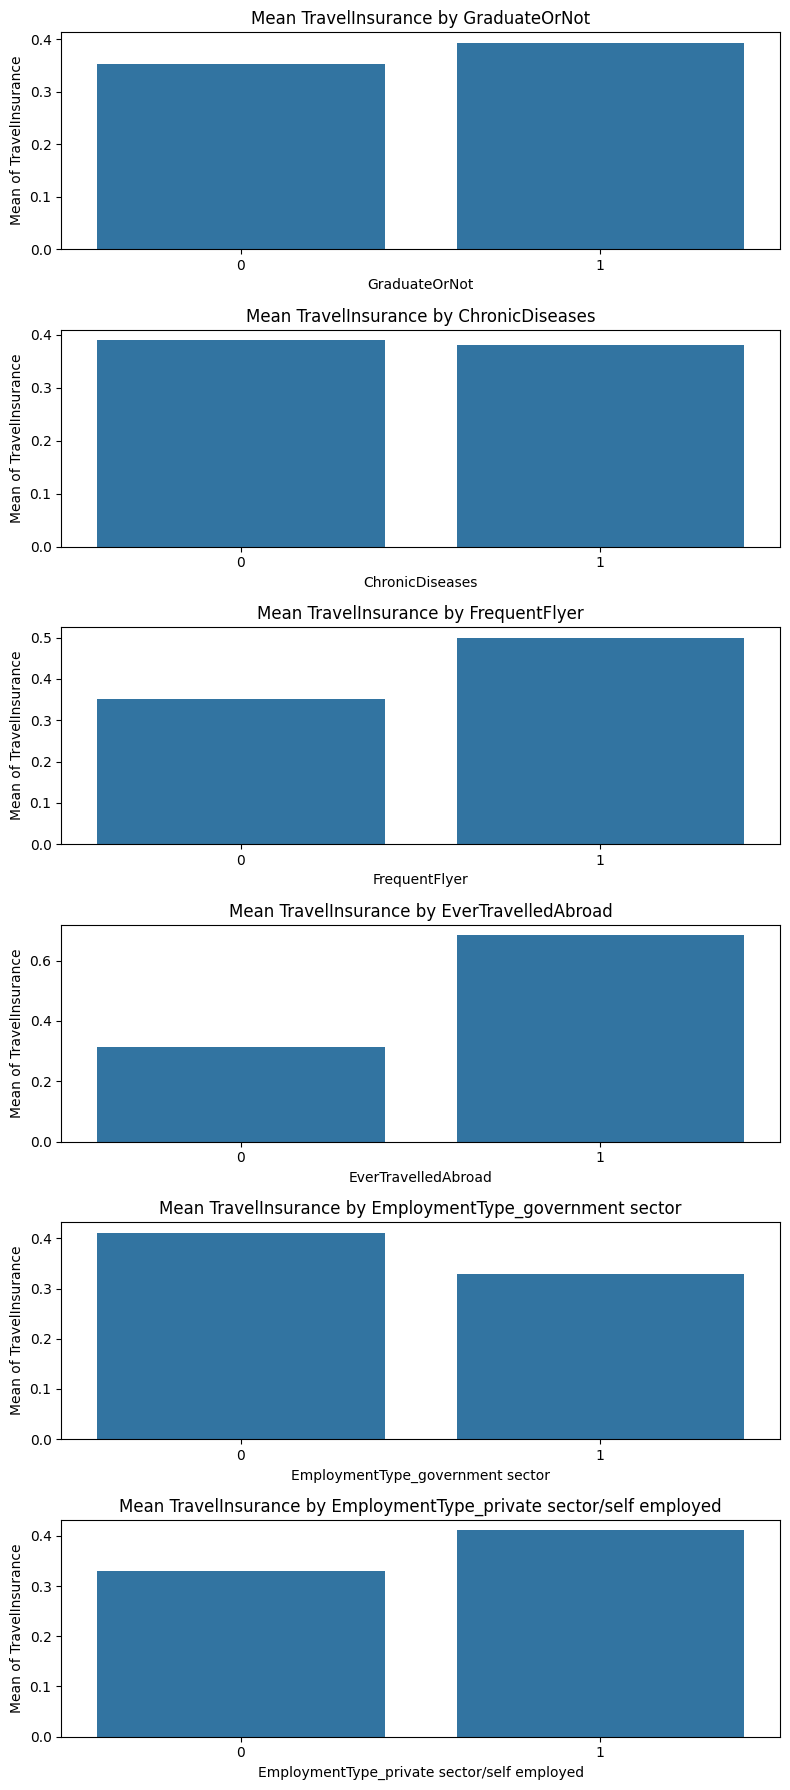

In [40]:
# Further Bivariate Analysis: Binary features vs TravelInsurance
binary_cols = [
    c for c in data.columns
    if data[c].dropna().isin([0, 1]).all() and c != "TravelInsurance"
]
if len(binary_cols) == 0:
    print("No binary columns found besides the target.")
else:
    fig, axes = plt.subplots(nrows=len(binary_cols), ncols=1, figsize=(8, 3*len(binary_cols)))
    if len(binary_cols) == 1:
        axes = [axes]
    for ax, c in zip(axes, binary_cols):
        sns.barplot(
            data=data,
            x=c,
            y="TravelInsurance",
            estimator="mean",
            errorbar=None,
            ax=ax,
        )
        ax.set_title(f"Mean TravelInsurance by {c}")
        ax.set_xlabel(c)
        ax.set_ylabel("Mean of TravelInsurance")
    plt.tight_layout()
    plt.show()

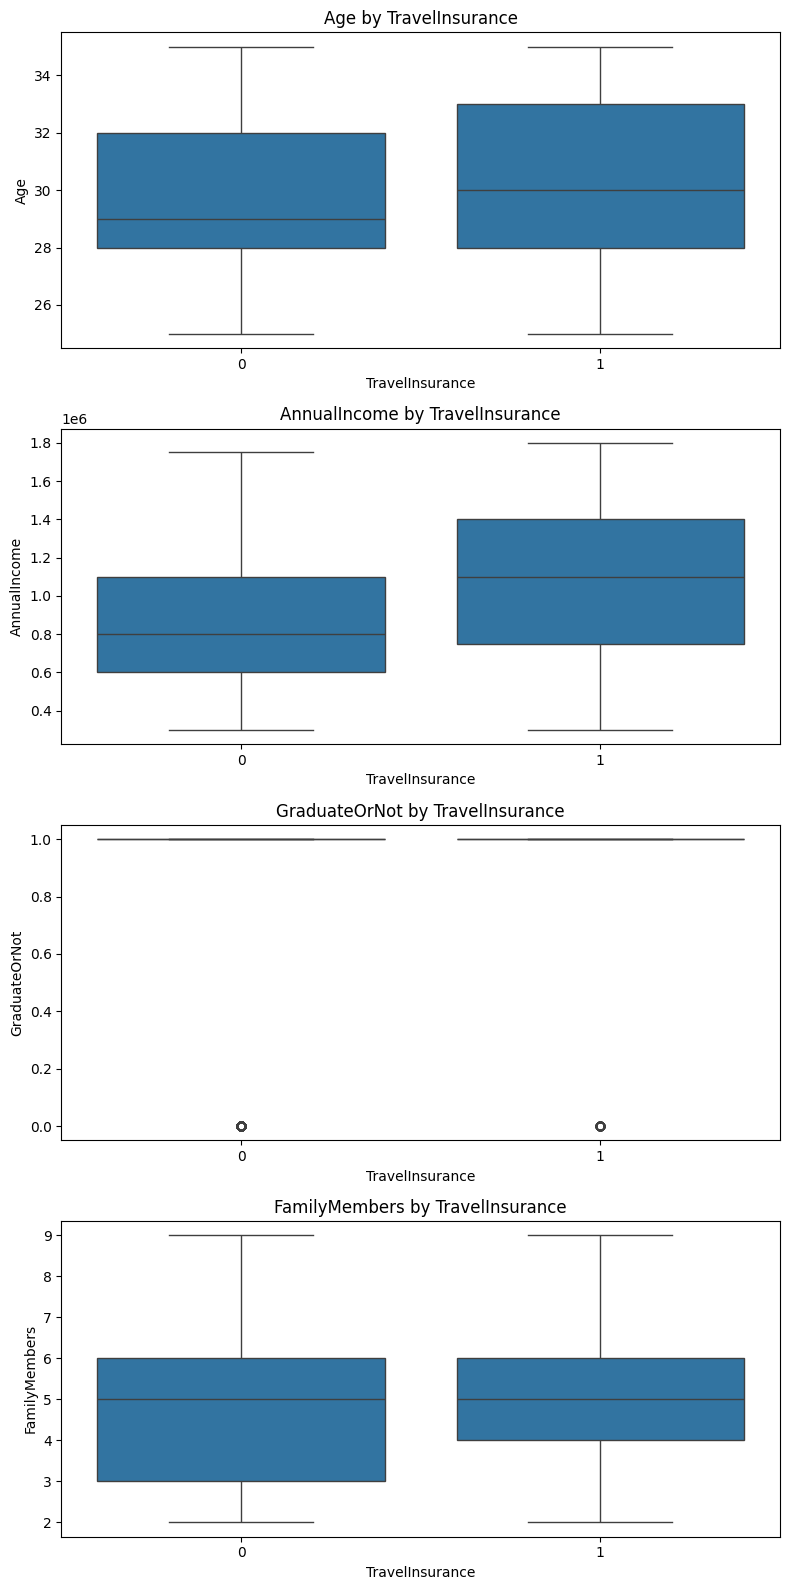

In [41]:
# Bivariate Analysis: Numeric features vs TravelInsurance (boxplots)
numeric_cols = [c for c in data.select_dtypes(include=["number"]).columns if c != "TravelInsurance"]

show_cols = []
for c in ["Age", "AnnualIncome"]:
    if c in numeric_cols:
        show_cols.append(c)
# add any remaining numeric columns up to 4 plots
for c in numeric_cols:
    if c not in show_cols and len(show_cols) < 4:
        show_cols.append(c)

if len(show_cols) == 0:
    print("No numeric columns to plot.")
else:
    fig, axes = plt.subplots(nrows=len(show_cols), ncols=1, figsize=(8, 4*len(show_cols)))
    if len(show_cols) == 1:
        axes = [axes]
    for ax, c in zip(axes, show_cols):
        sns.boxplot(data=data, x="TravelInsurance", y=c, ax=ax)
        ax.set_title(f"{c} by TravelInsurance")
    plt.tight_layout()
    plt.show()

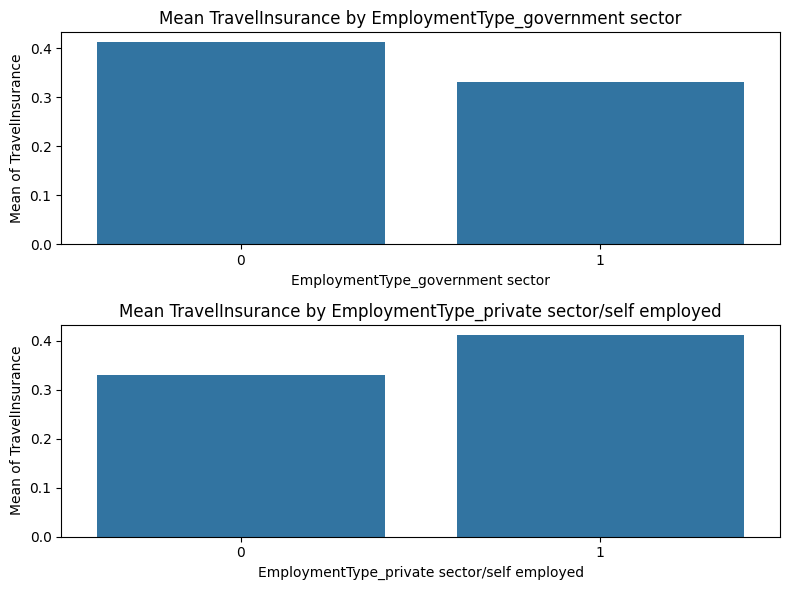

In [42]:
# Employment Type dummies vs TravelInsurance
emp_cols = [c for c in data.columns if c.startswith("EmploymentType_")]
if len(emp_cols) == 0:
    print("No EmploymentType dummies found to analyze.")
else:
    fig, axes = plt.subplots(nrows=len(emp_cols), ncols=1, figsize=(8, 3*len(emp_cols)))
    if len(emp_cols) == 1:
        axes = [axes]
    for ax, c in zip(axes, emp_cols):
        sns.barplot(data=data, x=c, y="TravelInsurance", estimator="mean", errorbar=None, ax=ax)
        ax.set_title(f"Mean TravelInsurance by {c}")
        ax.set_xlabel(c)
        ax.set_ylabel("Mean of TravelInsurance")
    plt.tight_layout()
    plt.show()

# Normalization

In [51]:
# Normalize continuous numeric features (leave binary 0/1 and target untouched)
# Produces data_norm, scaler, X, y

target = "TravelInsurance"

data_norm = data.copy()

# Numeric columns excluding target
numeric_cols = data_norm.select_dtypes(include=["number"]).columns.tolist()
if target in numeric_cols:
    numeric_cols.remove(target)

# Identify binary-like numeric columns (values only in {0,1})
binary_like_cols = []
for c in numeric_cols:
    vals = pd.to_numeric(data_norm[c], errors="coerce")
    uniq = set(vals.dropna().unique().tolist())
    if uniq.issubset({0, 1}):
        binary_like_cols.append(c)

cont_cols = [c for c in numeric_cols if c not in binary_like_cols]

# Impute medians for continuous columns
for c in cont_cols:
    data_norm[c] = pd.to_numeric(data_norm[c], errors="coerce")
    med = data_norm[c].median()
    data_norm[c].fillna(med, inplace=True)

# Scale continuous columns
scaler_name = None
try:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    data_norm[cont_cols] = scaler.fit_transform(data_norm[cont_cols])
    scaler_name = "StandardScaler"
except Exception as e:
    # Fallback: manual z-score
    scaler = None
    scaler_name = "manual-zscore"
    for c in cont_cols:
        mu = data_norm[c].mean()
        sigma = data_norm[c].std()
        if pd.notna(sigma) and sigma != 0:
            data_norm[c] = (data_norm[c] - mu) / sigma
        else:
            data_norm[c] = 0.0

# Prepare features/target for modeling
X = data_norm.drop(columns=[target])
y = data_norm[target].astype("Int64")

print(f"Normalized {len(cont_cols)} continuous columns using {scaler_name}.")
print("Continuous columns:", cont_cols[:10], "..." if len(cont_cols) > 10 else "")
print("Binary-like columns left unscaled:", binary_like_cols)
print("Shapes -> X:", X.shape, "y:", y.shape)

Normalized 3 continuous columns using StandardScaler.
Continuous columns: ['Age', 'AnnualIncome', 'FamilyMembers'] 
Binary-like columns left unscaled: ['GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']
Shapes -> X: (1248, 6) y: (1248,)


/tmp/ipykernel_398151/2529381719.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_norm[c].fillna(med, inplace=True)
/tmp/ipykernel_398151/2529381719.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

# Train Model

In [52]:
# Train Test
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np

# Ensure target has no NaNs and is int
y_clean = y.astype("Int64")
mask = y_clean.notna()
X_clean = X.loc[mask]
y_clean = y_clean.loc[mask].astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Try Logistic Regression first; fallback to RandomForest if it fails
model = None
try:
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
except Exception as e:
    print("LogisticRegression failed, fallback to RandomForest:", e)
    model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
prob = None
if hasattr(model, "predict_proba"):
    prob = model.predict_proba(X_test)[:, 1]
elif hasattr(model, "decision_function"):
    try:
        prob = model.decision_function(X_test)
    except Exception:
        prob = None

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# ROC-AUC (only if both classes present and probabilities available)
auc = None
if prob is not None and len(np.unique(y_test)) == 2:
    try:
        auc = roc_auc_score(y_test, prob)
        print(f"ROC-AUC: {auc:.4f}")
    except Exception as e:
        print("ROC-AUC not computed:", e)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

Accuracy: 0.6680
ROC-AUC: 0.6616

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.85      0.76       153
           1       0.62      0.38      0.47        97

    accuracy                           0.67       250
   macro avg       0.65      0.62      0.61       250
weighted avg       0.66      0.67      0.65       250

Confusion Matrix:
 [[130  23]
 [ 60  37]]

Train/Test shapes: (998, 6) (250, 6)


# Export Model

In [54]:
# Export trained model, scaler (if available), and metadata
import os, json, datetime
try:
    import joblib
except Exception:
    import pickle as joblib  # fallback alias with similar API: joblib.dump -> pickle.dump

# Ensure model exists
try:
    _ = model
except NameError:
    raise RuntimeError("Model not found. Run the training cell first.")

os.makedirs("artifacts", exist_ok=True)
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"artifacts/model_{ts}.pkl"
scaler_path = f"artifacts/scaler_{ts}.pkl"
meta_path = f"artifacts/meta_{ts}.json"

# Save model
try:
    joblib.dump(model, model_path)
except TypeError:
    # If we fell back to pickle alias, convert to pickle.dump signature
    import pickle
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

# Save scaler if available
scaler_saved = False
if 'scaler' in globals() and scaler is not None:
    try:
        joblib.dump(scaler, scaler_path)
        scaler_saved = True
    except TypeError:
        import pickle
        with open(scaler_path, "wb") as f:
            pickle.dump(scaler, f)
        scaler_saved = True

# Save metadata
meta = {
    "feature_columns": list(X.columns) if 'X' in globals() else None,
    "target": target if 'target' in globals() else None,
    "scaler_name": scaler_name if 'scaler_name' in globals() else None,
    "scaler_saved": scaler_saved,
    "model_class": type(model).__name__,
    "timestamp": ts,
}
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print("Saved:")
print(" - model:", model_path)
print(" - scaler:", scaler_path if scaler_saved else "(none)")
print(" - meta:", meta_path)

Saved:
 - model: artifacts/model_20250811_235624.pkl
 - scaler: artifacts/scaler_20250811_235624.pkl
 - meta: artifacts/meta_20250811_235624.json
